## Reading and plotting the gridded data

The preferred Moho model is an ensemble average over the best fitting model parameters and many different triangulations. The most straightforward means to distribute this information is as a finely triangulated grid together with a "quality" mask that indicates where the values are extrapolated.

To plot or contour this surface, we triangulate the points with `stripy`. We can also calculate the slope of this model from the triangulation but this is also available directly from the model file. 

There are three models provided in fine-grid form:

   - `MohoModel_opt` is the ensemble of models that lie within 1.25% of the model that best predicts the test data and 1.25% of the  model that best predicts all the data
   
   - `MohoModel_min` is the model that best predicts the test data
   - `MohoModel_minj` is the model that best predicts all the data (test plus training).
   
`stripy` allows us to extract information anywhere on the surface (and flags places where the interpolation becomes an extrapolation or fails 
altogether). We can use this to plot values along a section.

--- 

Notebooks in this section:

   - [A1-RawData-ConvertAndSave.ipynb](A1-RawData-ConvertAndSave.ipynb)
   - [A2-RawData-PlotQualityInformation.ipynb](A2-RawData-PlotQualityInformation.ipynb)
   - [A3-TriangulatingAndinterpolating.ipynb](A3-TriangulatingAndinterpolating.ipynb)
   - [A4-PlottingMohoAndMohoSlope.ipynb](A4-PlottingMohoAndMohoSlope.ipynb)
   - [A5-Interactive3DPlot.ipynb](A5-Interactive3DPlot.ipynb)
   - [A6-ConvertModels2RegularXYZ.ipynb](A6-ConvertModels2RegularXYZ.ipynb)






In [1]:
%matplotlib inline

import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


### Read and triangulate the data 

As previously, we read the raw and the finely finely-gridded solution and create a `stripy` triangulation for each one.

In [2]:
## These are the original data 

try:
       import miller_alaskamoho_srl2018 as alaskamoho
except ImportError:
       raise ("Problem importing the alaska moho package")


mohoraw     = alaskamoho.MohoErr
# mohorawgrid = stripy.sTriangulation(np.radians(mohoraw['lon']), np.radians(mohoraw['lat']), tree=True, permute=False)

msmoho_opt  = alaskamoho.MohoModel_opt
msmoho_min  = alaskamoho.MohoModel_min
msmoho_minj = alaskamoho.MohoModel_minj



## Plot with transparency in "boring" parts

Here we plot contours of the smooth surface allowing the terrain to show through in regions that are
close to the middle of the colour map.

In [3]:
def alaska_moho_plot(filename, 
                     model,
                     plot_range=[25.0, 50.0], 
                     show_coastline=True,
                     show_bg_image=True,
                     raw_data_points=None,
                     cmap=None ):
    
    goodgrid = model.gridF
    quality = model.quality
    grid_data = model.surface
    
    try:
        import gdal
        globalsrelief       = gdal.Open("ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]//4, 0:globalsrelief_img.shape[1]//4]
        
    except ImportError:
        show_bg_image = False
    
    if cmap == None:
        cmap = plt.cm.RdYlBu
        
    # Transparent colours
    from matplotlib.colors import ListedColormap

    colA = cmap(np.arange(cmap.N))
    colA[:,-1] = 0.25 + 0.5 * np.linspace(-1.0, 1.0, cmap.N)**2.0

    # Create new colormap
    cmapA = ListedColormap(colA)

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])
    
    
    grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", name="graticules_5")
    ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=2)
    

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)
    
    gdata2 = grid_data.copy()
    gdata2[ quality == 0.0 ] = -10000000
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmapA, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", 
                   transform=ccrs.PlateCarree(),
                         zorder=10)
    
    gdata2 = grid_data.copy()
    gdata2[ quality < 0.05 ] = -10000000
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmapA, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", 
                   transform=ccrs.PlateCarree(),
                         # alpha=0.5,
                         zorder=11)
       
    if raw_data_points is not None:

        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )
    
    fig.savefig(filename, dpi=600)

 

Surface combining all data within 1% of the best fit model to the test data


/Users/lmoresi/miniconda3/envs/miller-moho/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


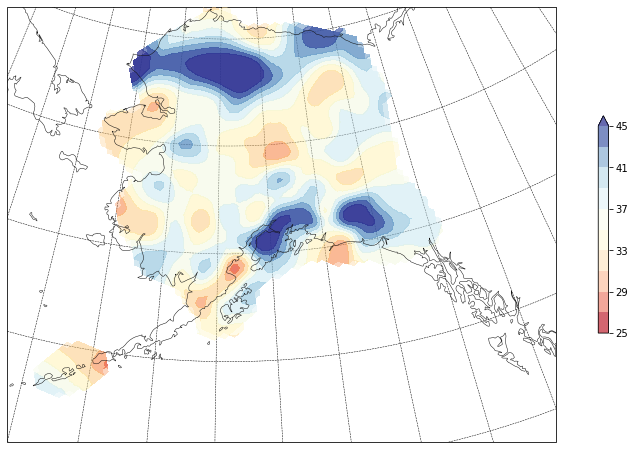

In [4]:
print(msmoho_opt.description)

alaska_moho_plot("Images/AlaskaMohoOpt1pct.png", 
                 msmoho_opt,
                 plot_range=[25, 45],
                 show_bg_image=True )


In [5]:
def alaska_moho_slope_plot(filename, 
                           model,
#                            grid, 
#                            data, 
#                            grad,
#                            quality, 
                           plot_range=[25.0, 50.0], 
                           show_coastline=True,
                           show_bg_image=True,
                           raw_data_points=None,
                           cmap=None ):
    
    goodgrid  = model.gridF
    grid_data = model.surface
    grad_data = model.surface_slope
    quality   = model.quality
   
    if cmap is None:
        cmap = plt.cm.Oranges
        
    # Transparent colours
    from matplotlib.colors import ListedColormap

    colA = cmap(np.arange(cmap.N))
    colA[:,-1] = np.linspace(0.0, 1.0, cmap.N)

    # Create new colormap
    cmapA = ListedColormap(colA)
            
    try:
        import gdal
        globalsrelief       = gdal.Open("ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]//4, 0:globalsrelief_img.shape[1]//4]
        
    except ImportError:
        show_bg_image = False



    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)
  
    gdata2 = grad_data.copy()
    gdata2[ quality == 0] = -1000000.0
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmapA, 
                   levels=np.linspace(0.0,0.1,11),
                   extend="max", 
                   transform=ccrs.PlateCarree(),
                         zorder=10)
    
    centroids_q, err = goodgrid.interpolate(goodgrid.lons[goodgrid.simplices].mean(axis=1), 
                                         goodgrid.lats[goodgrid.simplices].mean(axis=1), quality)
    
    
    mask = centroids_q == 0.0

    cnt=ax1.tricontour(lons, lats, goodgrid.simplices, grid_data, 
                   alpha=1.0, colors="#000000", mask=mask,
                   levels=[25, 29, 33, 37, 41, 45],
                   linewidths=[0.5,0.5, 0.75, 0.75, 1.0, 1.0],
                   linestyles=[":","-"],
                   transform=ccrs.PlateCarree(), 
                       zorder=50) 
     
    ## Locations of raw data collection

    if raw_data_points is not None:

        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )
    
    fig.savefig(filename, dpi=600)



/Users/lmoresi/miniconda3/envs/miller-moho/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: The following kwargs were not used by contour: 'mask'
/Users/lmoresi/miniconda3/envs/miller-moho/lib/python3.7/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


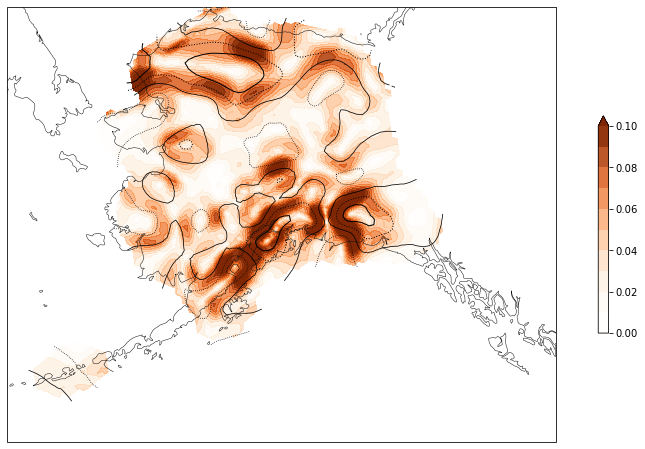

In [6]:
alaska_moho_slope_plot("Images/AlaskaMohoSlopeOpt1pct.png", 
                        msmoho_opt,
                        plot_range=[25, 45],
                        show_bg_image=True )

## Cross section and comparison

In [7]:

llo, lla = stripy.spherical.great_circle_Npoints(np.radians([-149, 60]), np.radians([-149, 70]), 100)

lls = np.recarray(shape=(llo.shape), formats=['f8', 'f8'], names=['lon', 'lat'])

lls['lon'] = np.degrees(llo)
lls['lat'] = np.degrees(lla)

moho_line,  err = msmoho_opt.gridF.interpolate(llo,lla, msmoho_opt.surface)

pts = np.logical_and(mohoraw['lon'] < -148, mohoraw['lon'] > -150)

points_used = mohoraw[pts]

/Users/lmoresi/miniconda3/envs/miller-moho/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1624: UserWarning: You passed a edgecolor/edgecolors ('Black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = matplotlib.axes.Axes.scatter(self, *args, **kwargs)
/Users/lmoresi/miniconda3/envs/miller-moho/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


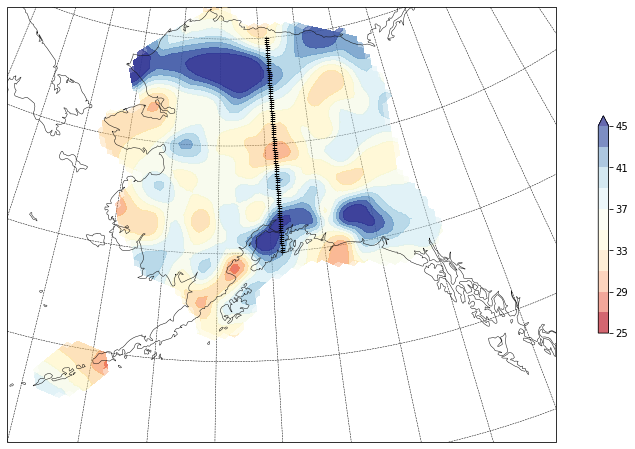

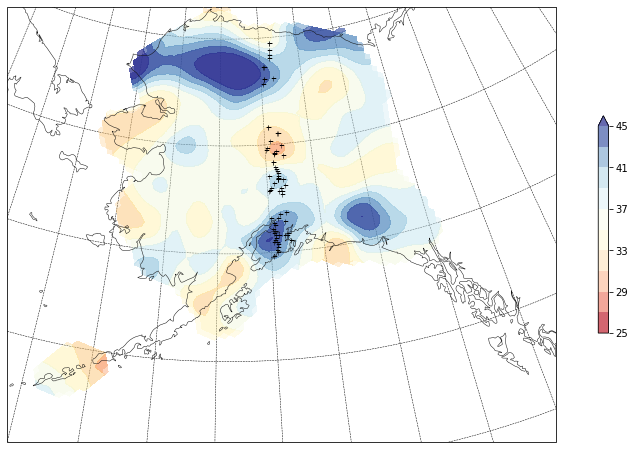

In [10]:
alaska_moho_plot("tmp.png", 
                 msmoho_opt,
                 plot_range=[25, 45],
                 show_bg_image=True,
                 raw_data_points=lls)


alaska_moho_plot("tmp.png", 
                 msmoho_min, 
                 plot_range=[25, 45],
                 show_bg_image=True,
                 raw_data_points=points_used)


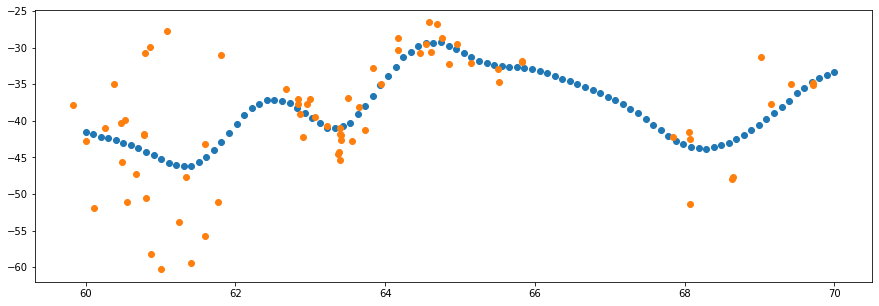

In [11]:

fig = plt.figure(figsize=(15, 5), facecolor=None)
ax1  = plt.subplot(111)
ax1.scatter(lls['lat'], -moho_line)
ax1.scatter(mohoraw['lat'][pts], -mohoraw['moh'][pts])


In [12]:
import numpy as np

try:
       import miller_alaskamoho_srl2018 as alaskamoho
except ImportError:
       print ("Problem importing the alaska moho package")


# Check the data files exist / can be read
# [('lon', '<f8'), ('lat', '<f8'), ('moh', '<f8') ... etc 
# [-174.197495 -171.703506 -170.247696 -168.854996 -168.161896]
# [43.61043017 34.75098075 37.34819411]

mohoraw = alaskamoho.MohoErr
print(mohoraw.dtype)
print(mohoraw['lon'][0:5])
print(mohoraw['moh'][0:5])



# Check to see if the sampler works
moho_model = alaskamoho.MohoModel_opt
lons = np.array([-150, -155, -160])
lats = np.array([60, 65, 70])
print(moho_model.value_at_lonlat_degrees(lons, lats, order=1))

# install documentation in user-specified location
alaskamoho.documentation.install_documentation("path/to/notebooks")


[('lon', '<f8'), ('lat', '<f8'), ('moh', '<f8'), ('xxx', '<f8'), ('stn', 'O'), ('min_err', '<f8'), ('mean_err', '<f8'), ('variance', '<f8'), ('q_score', '<f8')]
[-174.197495 -171.703506 -170.247696 -168.854996 -168.161896]
[42.435748 33.323598 29.234813 19.655374 25.963785]
[43.61043017 34.75098075 37.34819411]


In [13]:
import miller_alaskamoho_srl2018 as alaskamoho


# This is the preferred model 

moho_model = alaskamoho.MohoModel_opt
print(moho_model.description)
lons = np.array([-150, -155, -160])
lats = np.array([60, 65, 70])
print(moho_model.value_at_lonlat_degrees(lons, lats, order=1))


# This model is the single best fit to the test data only

moho_model = alaskamoho.MohoModel_min
print(moho_model.description)
lons = np.array([-150, -155, -160])
lats = np.array([60, 65, 70])
print(moho_model.value_at_lonlat_degrees(lons, lats, order=1))

# This model is the single best fit to the test data and the training data combined

moho_model = alaskamoho.MohoModel_minj
print(moho_model.description)
lons = np.array([-150, -155, -160])
lats = np.array([60, 65, 70])
print(moho_model.value_at_lonlat_degrees(lons, lats, order=1))


Surface combining all data within 1% of the best fit model to the test data
[43.61043017 34.75098075 37.34819411]
Surface with best fit to test data across all realisations
[42.54082505 35.56872498 38.91066727]
Surface with best fit to test+training data across all realisations
[44.18229324 34.31220598 36.15598061]
